### Cats And Dogs Classifier With Transfer Learning

In [4]:
# import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, sys, time

In [2]:
# read the data
data_path = "data/dogs_cats"
train_path = "data/dogs_cats/train"
validation_path = "data/dogs_cats/validation"

print("\033[4mTRAINING DATA\033[0m")
train_cats_names = os.listdir(os.path.join(train_path, "cats"))
train_dogs_names = os.listdir(os.path.join(train_path, "dogs"))

print("Cats: {}".format(len(train_cats_names)))
print("Dats: {}".format(len(train_dogs_names)))

cat_img = mpimg.imread(os.path.join(train_path, "cats", train_cats_names[0]))
dog_img = mpimg.imread(os.path.join(train_path, "dogs", train_dogs_names[0]))
print(f"Cat Image Shape: {cat_img.shape}")
print(f"Dog Image Shape: {dog_img.shape}")

## Validation Data
print("\033[4m\n\nTesting DATA\033[0m")
val_cats_names = os.listdir(os.path.join(validation_path, "cats"))
val_dogs_names = os.listdir(os.path.join(validation_path, "dogs"))

print("Cats: {}".format(len(val_cats_names)))
print("Dats: {}".format(len(val_dogs_names)))

cat_img = mpimg.imread(os.path.join(validation_path, "cats", val_cats_names[0]))
dog_img = mpimg.imread(os.path.join(validation_path, "dogs", val_dogs_names[0]))
print(f"Cat Image Shape: {cat_img.shape}")
print(f"Dog Image Shape: {dog_img.shape}")

TRAINING DATA
Cats: 1000
Dats: 1000
Cat Image Shape: (374, 500, 3)
Dog Image Shape: (500, 332, 3)


Testing DATA
Cats: 500
Dats: 500
Cat Image Shape: (499, 459, 3)
Dog Image Shape: (339, 200, 3)


In [55]:
# Some Constants
BATCH_SIZE = 20
TARGET_SIZE = (150, 150)
CLASS_MODE = 'binary'
EPOCHS = 2
WIDTH, HEIGHT, CHANNELS = cat_img.shape
TRAIN_DATA_SIZE = len(train_cats_names) + len(train_dogs_names)
VAL_DATA_SIZE = len(val_cats_names) + len(val_dogs_names)

In [56]:
# preprocess the data
# those operations will be done using the imageGenerator class 'normalization', `reshaping`, 'etc'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------------
# Flow training images in batches of 20 using train_datagen generator (data augmentation)
# --------------------
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      horizontal_flip=True,
#                                     vertical_flip=True,
                                      fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=CLASS_MODE,
                                                    target_size=TARGET_SIZE)

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
validation_generator =  validation_datagen.flow_from_directory(validation_path,
                                                         batch_size  =BATCH_SIZE,
                                                         class_mode  = CLASS_MODE,
                                                         target_size = TARGET_SIZE)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [57]:
inception_model_path = "models/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(inception_model_path)

# lock/freeze the layers from training.
for layer in pre_trained_model.layers:
  layer.trainable = False


In [58]:
layers_info = [(layer.name, layer.output_shape) for layer in pre_trained_model.layers]
print(f"layer {len(layers_info)} with name {layers_info[-1][0]} with shape {layers_info[-1][1]}" )

layer 311 with name mixed10 with shape (None, 3, 3, 2048)


In [59]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [60]:
# define your own custom DNN that will be connected with the already trained convnet model
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024, activation="relu")(x)
# x = keras.layers.BatchNormalization()(x),
x = keras.layers.Dropout(0.2)(x)  
x = keras.layers.Dense(1, activation="sigmoid")(x)

model =  keras.Model(pre_trained_model.input, x)

model.compile(optimizer = keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# model.Summery()

In [61]:
history = model.fit( train_generator, 
          validation_data=validation_generator,
          epochs=EPOCHS,
          steps_per_epoch=TRAIN_DATA_SIZE/BATCH_SIZE,
          validation_steps=VAL_DATA_SIZE/BATCH_SIZE,
          verbose = 2)

Epoch 1/2
100/100 - 160s - loss: 1.1515 - accuracy: 0.5012 - val_loss: 0.9549 - val_accuracy: 0.4985
Epoch 2/2
100/100 - 196s - loss: 0.9069 - accuracy: 0.4983 - val_loss: 0.9041 - val_accuracy: 0.5029


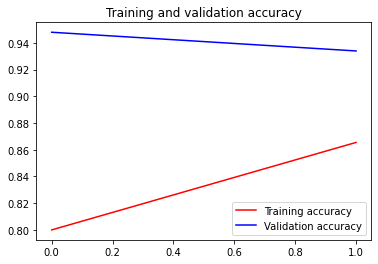

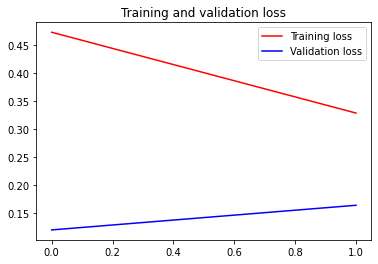

<Figure size 432x288 with 0 Axes>

In [35]:
# graph train_acc vs val_acc
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()